## Digit Recognizer<p>
<p>This project walks through building a convolutional neural network model that can automatically predict the correct label (number) on the MNIST dataset :</p>
<p><img src="https://miro.medium.com/max/2200/1*XdCMCaHPt-pqtEibUfAnNw.png" alt="Image classification with MNIST Dtaset"></p>



# 1. Import Python libraries


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.callbacks import EarlyStopping
from keras.utils import normalize
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/test.csv


/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

# 2. Data preparation
Let's load  our Data first

In [2]:
train_data = pd.read_csv('../input/digit-recognizer/train.csv') #load train data
test_data  = pd.read_csv('../input/digit-recognizer/test.csv') #load test data

In [3]:
# separate label from the data
X_train = train_data.drop(labels = ['label'], axis=1) 
y_train = train_data['label']

print('label values distribution:', y_train.value_counts())

label values distribution: 1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64


Let's check for missings values

In [4]:
print('missing values in train data:', X_train.isnull().sum().sum() )
print ('missing values in test data:', test_data.isnull().sum().sum())

missing values in train data: 0
missing values in test data: 0


* ### Normalize image data : <p>
Now we need to normalize our image data. Normalization is a general term that means changing the scale of our data so it is consistent. <p>
In this case, we want each feature to have a similar range so our neural network can learn effectively across all the features.<p>
So, we divide or Data by 255 to perform a grayscale normalization:

In [5]:
X_train = X_train / 255.0
X_test = test_data / 255.0

In [6]:
# Reshape image data
X_train = X_train.values.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.values.reshape(X_test.shape[0], 28, 28, 1)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (42000, 28, 28, 1)
X_test shape: (28000, 28, 28, 1)


This is a classification problem and the labels are 10 digits numbers from 0 to 9.So,  We need to encode these lables to one hot vectors

In [7]:
#One hot encoding labels
y_train= to_categorical(y_train, num_classes=10)

* ### Split train data into train and validation sets. <p>
Now that we have our image  train data matrix, X_train, as well as our labels, y_train, we can split our data into train and validation sets. To do this, we'll allocate 20% of the data into validation set. This is data that the model never sees during training and will be used to score our trained model.

In [8]:
#split data into train and validation sets
Xtrain, Xval, ytrain, yval = train_test_split(X_train, y_train, test_size = 0.2, random_state=124)


# 3. Model building
It's time to start building our deep learning model, a convolutional neural network (CNN). CNNs are a specific kind of artificial neural network that is very effective for image classification because they are able to take into account the spatial coherence of the image, i.e., that pixels close to each other are often related.<p>

Building a CNN begins with specifying the model type. In our case, we'll use a Sequential model, which is a linear stack of layers. To understand convolutional layers, imagine a flashlight being shown over the top left corner of the image and slowly sliding across all the areas of the image, moving across the image in the same way your eyes move across words on a page. Convolutional layers pass a kernel (a sliding window) over the image and perform element-wise matrix multiplication between the kernel values and the pixel values in the image. <p>
    
After specifying the model type, we'll add the following layers:

* Conv2D : This adds a first convolutional layer with 32 filters
* Conv2D: This adds a second convolutional layer with 64 filters
* MaxPooling: This passes a (2, 2) moving window over the image and downscales the image by outputting the maximum value within the window.
* Conv2D: This adds a third convolutional layer since deeper models, i.e. models with more convolutional layers, are better able to learn features from images.
* Dropout: This prevents the model from overfitting, i.e. perfectly remembering each image, by randomly setting 25% of the input units to 0 at each update during training.
* Flatten: As its name suggests, this flattens the output from the convolutional part of the CNN into a one-dimensional feature vector which can be passed into the following fully connected layers.
* Dense: Fully connected layer where every input is connected to every output (see image below).
* Dropout: Another dropout layer to safeguard against overfitting, this time with a rate of 50%.
* Dense: Final layer which calculates the probability the image is containing the right number.
To take a look at how it all stacks up, we'll print the model summary. Notice that our model has a whopping 1,662,794 paramaters. These are the different weights that the model learns through training and what are used to generate predictions on a new image.

In [9]:
model = Sequential()
model.add(Conv2D(32, kernel_size = (3,3), activation='relu',padding='Same', input_shape=(28,28,1)))
model.add(Conv2D(64, kernel_size = (3,3), activation='relu',padding='Same'))

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size = (3,3), activation='relu',padding='Same'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(10, activation = 'softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1605760   
__________

# 4. Compile and train model
Now that we've specified the model architecture, we will compile the model for training. For this we need to specify the loss function (what we're trying to minimize), the optimizer (how we want to go about minimizing the loss), and the metric (how we'll judge the performance of the model)

In [10]:
model.compile(optimizer= keras.optimizers.SGD(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

Since training is computationally intensive, we'll do the training , using the train set and training for 20 epochs. Epochs refer to the number of iterations over the data.

In [11]:
early_stopping_monitor = EarlyStopping(patience=2)
fitting = model.fit(Xtrain, ytrain, epochs=20,validation_split = 0.2, callbacks=[early_stopping_monitor])

Train on 26880 samples, validate on 6720 samples
Epoch 1/20
26880/26880 [==============================] - 77s 3ms/step - loss: 2.1360 - acc: 0.3190 - val_loss: 1.5408 - val_acc: 0.7287
Epoch 2/20
26880/26880 [==============================] - 77s 3ms/step - loss: 0.9985 - acc: 0.6981 - val_loss: 0.4677 - val_acc: 0.8766
Epoch 3/20
26880/26880 [==============================] - 77s 3ms/step - loss: 0.6162 - acc: 0.8060 - val_loss: 0.3595 - val_acc: 0.8954
Epoch 4/20
26880/26880 [==============================] - 77s 3ms/step - loss: 0.5186 - acc: 0.8410 - val_loss: 0.3131 - val_acc: 0.9094
Epoch 5/20
26880/26880 [==============================] - 77s 3ms/step - loss: 0.4559 - acc: 0.8593 - val_loss: 0.2842 - val_acc: 0.9171
Epoch 6/20
26880/26880 [==============================] - 77s 3ms/step - loss: 0.4149 - acc: 0.8738 - val_loss: 0.2624 - val_acc: 0.9222
Epoch 7/20
26880/26880 [==============================] - 77s 3ms/step - loss: 0.3790 - acc: 0.8841 - val_loss: 0.2378 - val_acc:

# 5. Evaluate the model

Let's use the evaluate method to see how well the model did at classifying the MNIST data

In [12]:
score = model.evaluate(Xval, yval, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

validation loss: 0.1260939414302508
validation accuracy: 0.9635714285714285


We can evaluate our model using the confusion matrix

In [13]:

y_hat = model.predict(Xval)
y_pred = np.argmax(y_hat, axis=1)
y_true = np.argmax(yval, axis=1)
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[835   0   1   0   1   0   2   0   2   2]
 [  0 924   7   0   1   0   3   2   2   1]
 [  3   1 785   9   6   0   4   8   1   1]
 [  2   2   9 795   0  13   1   5   5   4]
 [  1   2   5   0 734   0   7   0   1  16]
 [  3   1   0  12   3 756   3   1   1   6]
 [  6   1   0   0   4   4 829   0   0   0]
 [  0   4   9   2   3   0   0 883   1   5]
 [  1   6   4   7   6   9   5   5 765   6]
 [  5   1   0  13  17   3   0  10   9 788]]


# 6. Visualize model training history

In addition to scoring the final iteration of the trained model as we just did, we can also see the evolution of scores throughout training thanks to the History object.

Notice how the accuracy improves over time, eventually leveling off. Correspondingly, the loss decreases over time. Plots like these can help diagnose overfitting. If we had seen an upward curve in the validation loss as times goes on (a U shape in the plot), we'd suspect that the model was starting to memorize the test set and would not generalize well to new data.

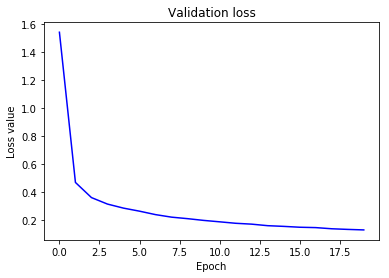

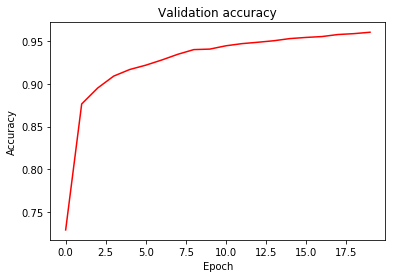

In [14]:
plt.plot(fitting.history['val_loss'], color='b')
plt.title('Validation loss')
plt.ylabel('Loss value')
plt.xlabel('Epoch')
plt.show()
plt.plot(fitting.history['val_acc'], color='r')
plt.title('Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()